For the past five years, you've honed your skills as a Senior Data Scientist for a global university. Your team leverages its data analytics and machine learning skill sets to help other departments make data-driven decisions. One such department is the procurement team, who is trying to decide the best new mobile phone to offer to the university's employees. For the last week, a Junior Data Scientist on your team has been developing a workflow to help provide insight to the procurement team. You will be reviewing their code to ensure it's ready to ship to production. 

The first chunk of code that you'll be reviewing is your colleague's function to prepare smartphone data from a CSV file for visualization. After ingesting and cleaning the smartphone data, your colleague has prepared a function to plot a variable passed to the function, versus `"price"`. However, within this function, there is code that does not adhere to DRY principles and is copied and pasted. Make sure to refactor the code appropriately, using the `column_to_label()` function defined below.

Wow, your colleague even included a unit test to ensure `NaN` values were removed from the cleaned DataFrame! However, it doesn't seem like the unit test is passing when executed. Re-work this unit test to ensure that it matches the transformation logic in the `prepare_smartphone_data()` function.

Once you've made changes to the `test_nan_values` unit test, you'll want to ensure that these unit tests execute with `ExitCode.OK`. This means that the `pytest` defined above has passed testing, and the code is one step closer to being to be shipped to production.

For context, there is a print statement in the `prepare_smartphone_data()` function in the first cell of the notebook below that can be used to visualize the dataset your Junior Data Engineer has been working with. Feel free to update this line of code as needed. This can then be removed after the dataset has been investigated. Best of luck!

In [5]:
# === Required Libraries ===
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pytest
import ipytest
from pathlib import Path

# Clean Data Preparation Function

In [12]:
def prepare_smartphone_data(file_path):
    """
    Reads and prepares smartphone data for visualization by:
    
    - Checking file existence
    - Retaining necessary features for analysis
    - Dropping rows with missing values in 'battery_capacity' or 'os'
    - Converting price from cents to dollars
    
    Args:
        file_path (str): Path to the raw smartphone CSV data
    
    Returns:
        pd.DataFrame: Cleaned smartphone data ready for visualization
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found at: {file_path}")

    # Load the raw dataset
    raw_data = pd.read_csv(file_path)

    # Keep only relevant columns for analysis
    selected_columns = [
        "brand_name", "os", "price", "avg_rating",
        "processor_speed", "battery_capacity", "screen_size"
    ]
    clean_data = raw_data.loc[:, selected_columns]

    # Remove rows with missing battery capacity or OS
    clean_data = clean_data.dropna(subset=["battery_capacity", "os"])

    # Convert price from cents to dollars
    clean_data["price"] = clean_data["price"] / 100

    return clean_data

# Label Formatter

In [13]:
def column_to_label(column_name):
    """
    Converts column names from snake_case to Title Case for plotting.

    Args:
        column_name (str): Column name

    Returns:
        str: Title-cased label string
    """
    if not isinstance(column_name, str):
        raise ValueError("Column name must be a string.")

    return " ".join(column_name.split("_")).title()

# Visualization Function

In [14]:
def visualize_versus_price(clean_data, x):
    """
    Plots a seaborn scatterplot for the given column vs. price.

    Args:
        clean_data (pd.DataFrame): Cleaned smartphone data
        x (str): Column name to plot against 'price'

    Returns:
        None
    """
    x_label = column_to_label(x)

    sns.scatterplot(x=x, y="price", data=clean_data, hue="os")
    plt.xlabel(x_label)
    plt.ylabel("Price ($)")
    plt.title(f"{x_label} vs. Price")
    plt.show()

# Load and Visualize (for test run)

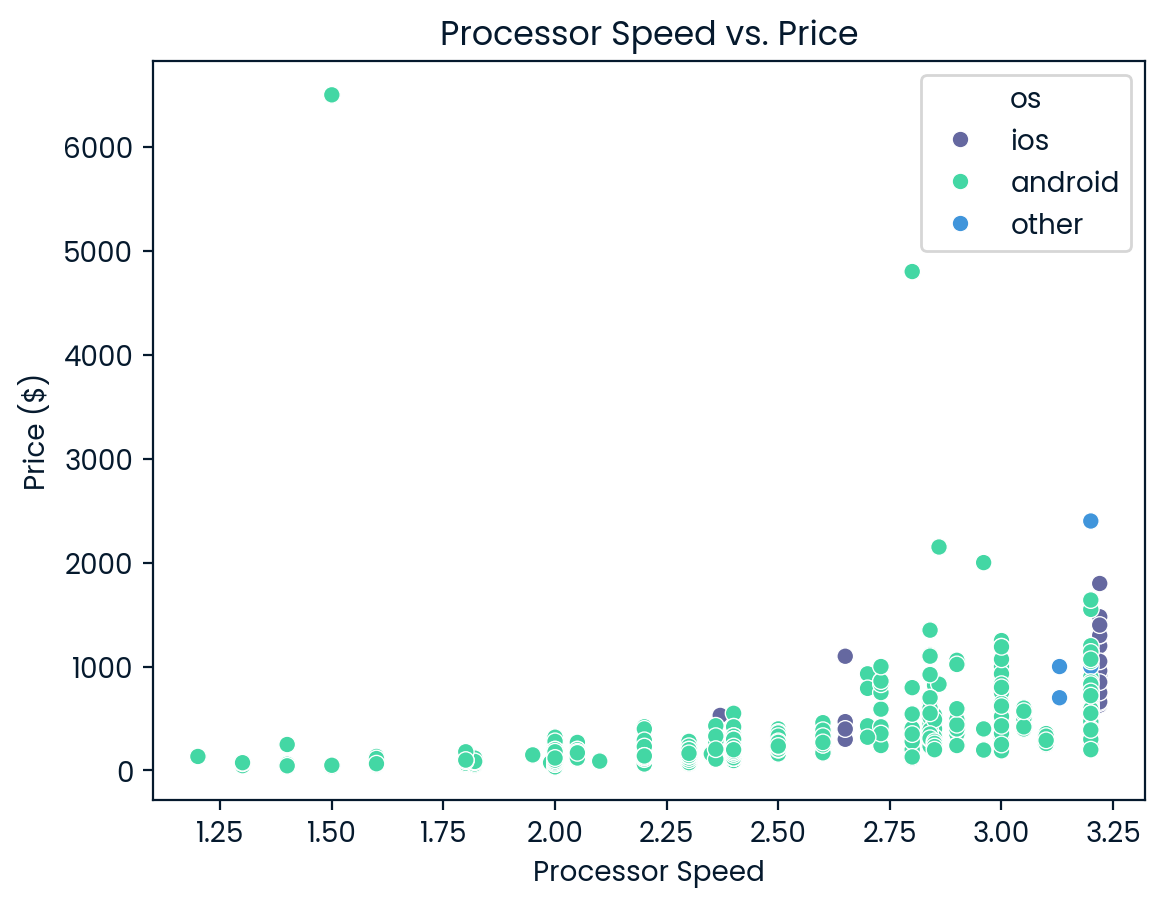

In [15]:
# Load and preview the data
cleaned_data = prepare_smartphone_data("./data/smartphones.csv")

# Example plot: Processor Speed vs Price
visualize_versus_price(cleaned_data, "processor_speed")

# Unit Test Setup

In [16]:
# Setup for running tests inside Jupyter Notebook
ipytest.config.rewrite_asserts = True
__file__ = "notebook.ipynb"

# Fixture to reuse cleaned data
@pytest.fixture()
def clean_smartphone_data():
    return prepare_smartphone_data("./data/smartphones.csv")

# Test for missing values
def test_nan_values(clean_smartphone_data):
    """
    Test that NaN values in 'battery_capacity' and 'os' have been removed.
    """
    assert clean_smartphone_data["battery_capacity"].isnull().sum() == 0
    assert clean_smartphone_data["os"].isnull().sum() == 0

# Run the test
ipytest.run()

======================================= test session starts ========================================
platform linux -- Python 3.8.10, pytest-7.1.2, pluggy-1.0.0
rootdir: /work/files/workspace
plugins: dash-2.13.0, web3-5.31.0, anyio-3.6.1
collected 1 item

t_a21f2f8e1d4e472e95105ce0945ac754.py .                                                      [100%]

======================================== 1 passed in 0.07s =========================================


<ExitCode.OK: 0>

## Price distribution

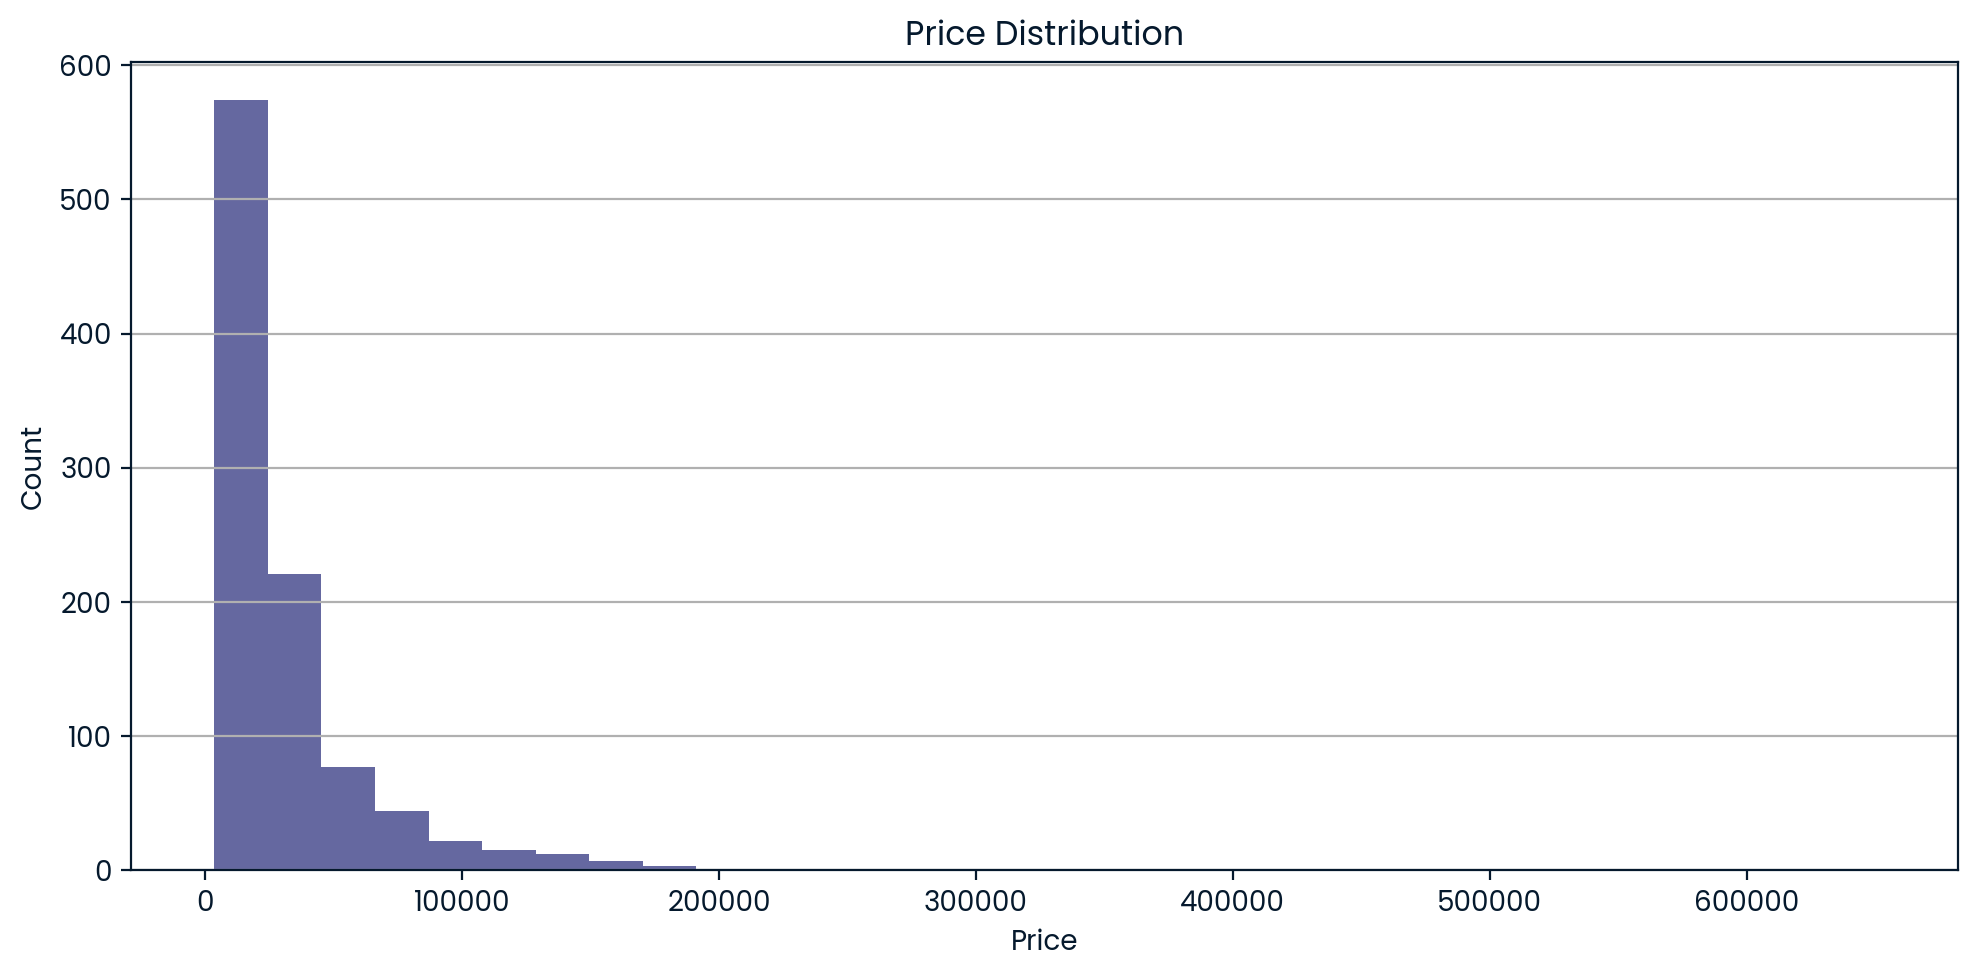

In [9]:
plt.figure(figsize=(10, 5))
vals = df["price"].dropna().values
bins = int(np.sqrt(len(vals))) if len(vals) > 0 else 30  # Freedman–Diaconis-ish simple choice
plt.hist(vals, bins=bins)
_finalize("Price Distribution", xlabel="Price", ylabel="Count",
          save_as="figures/price_distribution.png")

## Price by OS (bar)

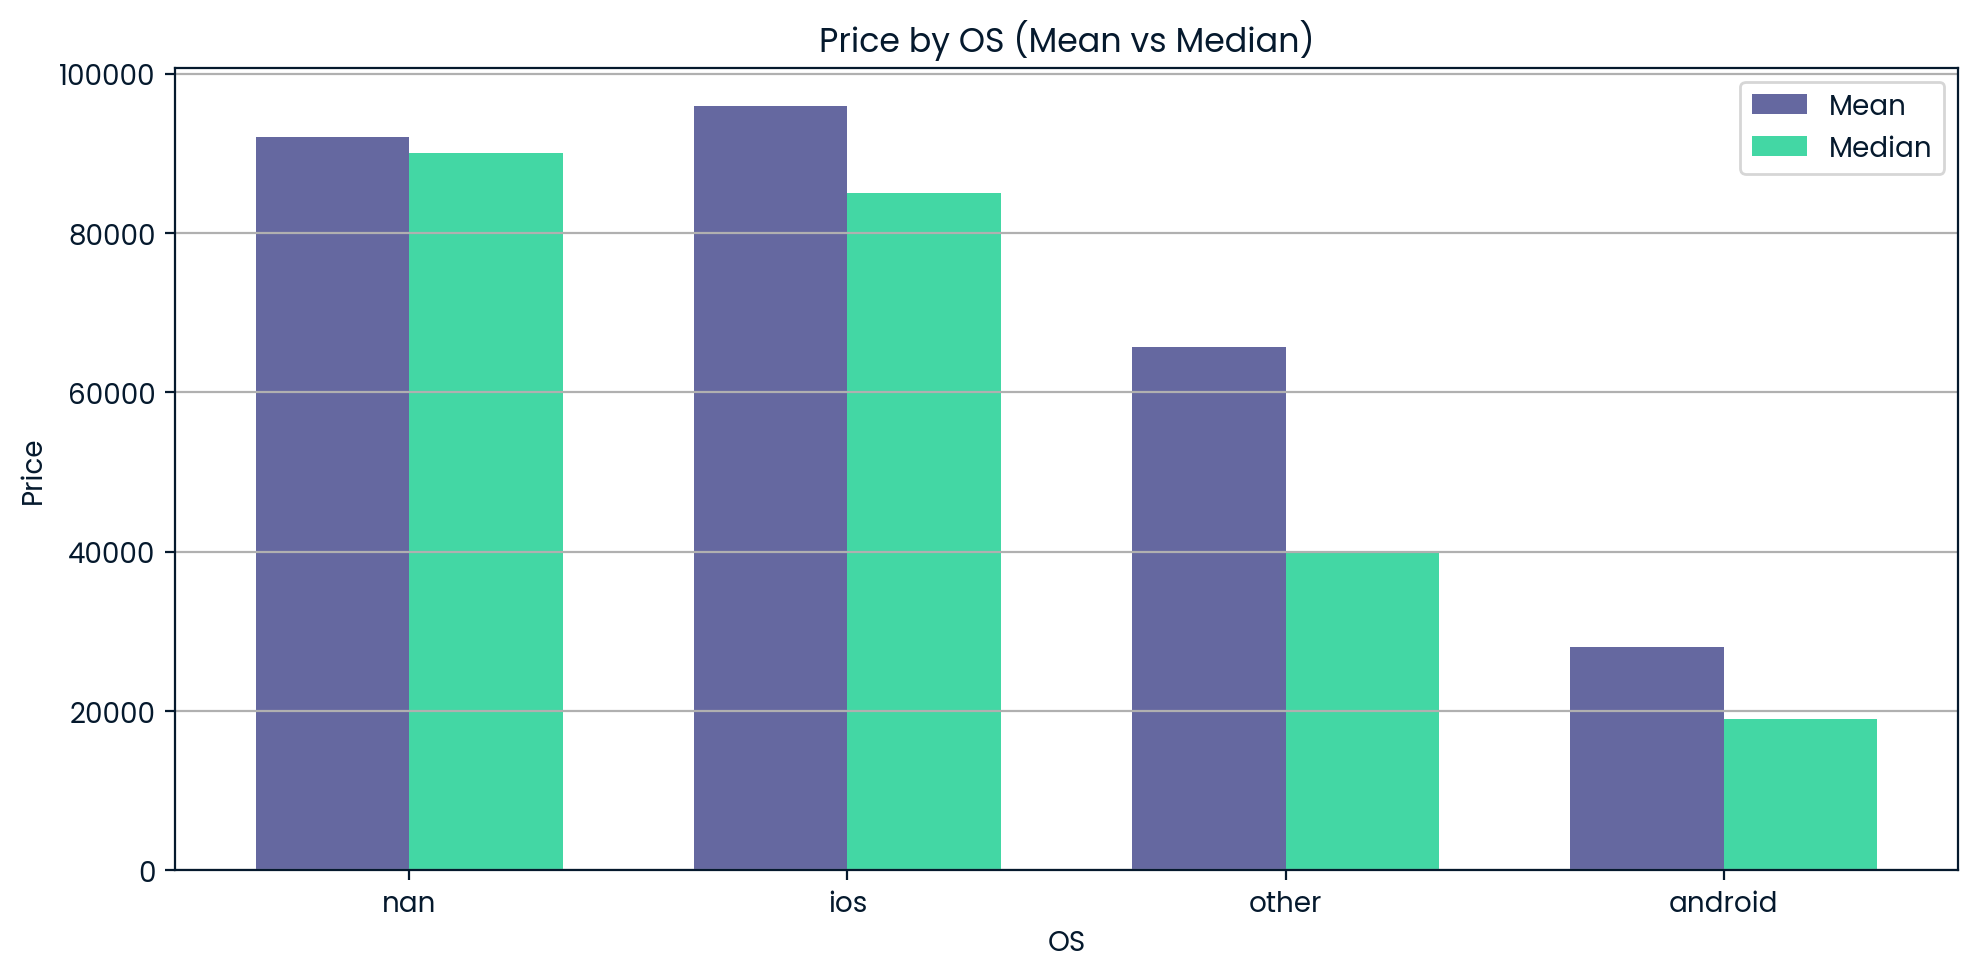

In [10]:
plt.figure(figsize=(10, 5))
g_os = df.groupby("os")["price"].agg(["count", "mean", "median"]).sort_values("median", ascending=False)
x = np.arange(len(g_os))
bar_w = 0.35
plt.bar(x - bar_w/2, g_os["mean"].values, width=bar_w, label="Mean")
plt.bar(x + bar_w/2, g_os["median"].values, width=bar_w, label="Median")
plt.xticks(x, g_os.index)
plt.legend()
_finalize("Price by OS (Mean vs Median)", xlabel="OS", ylabel="Price",
          save_as="figures/price_by_os.png")

## Top 6 brands by median price

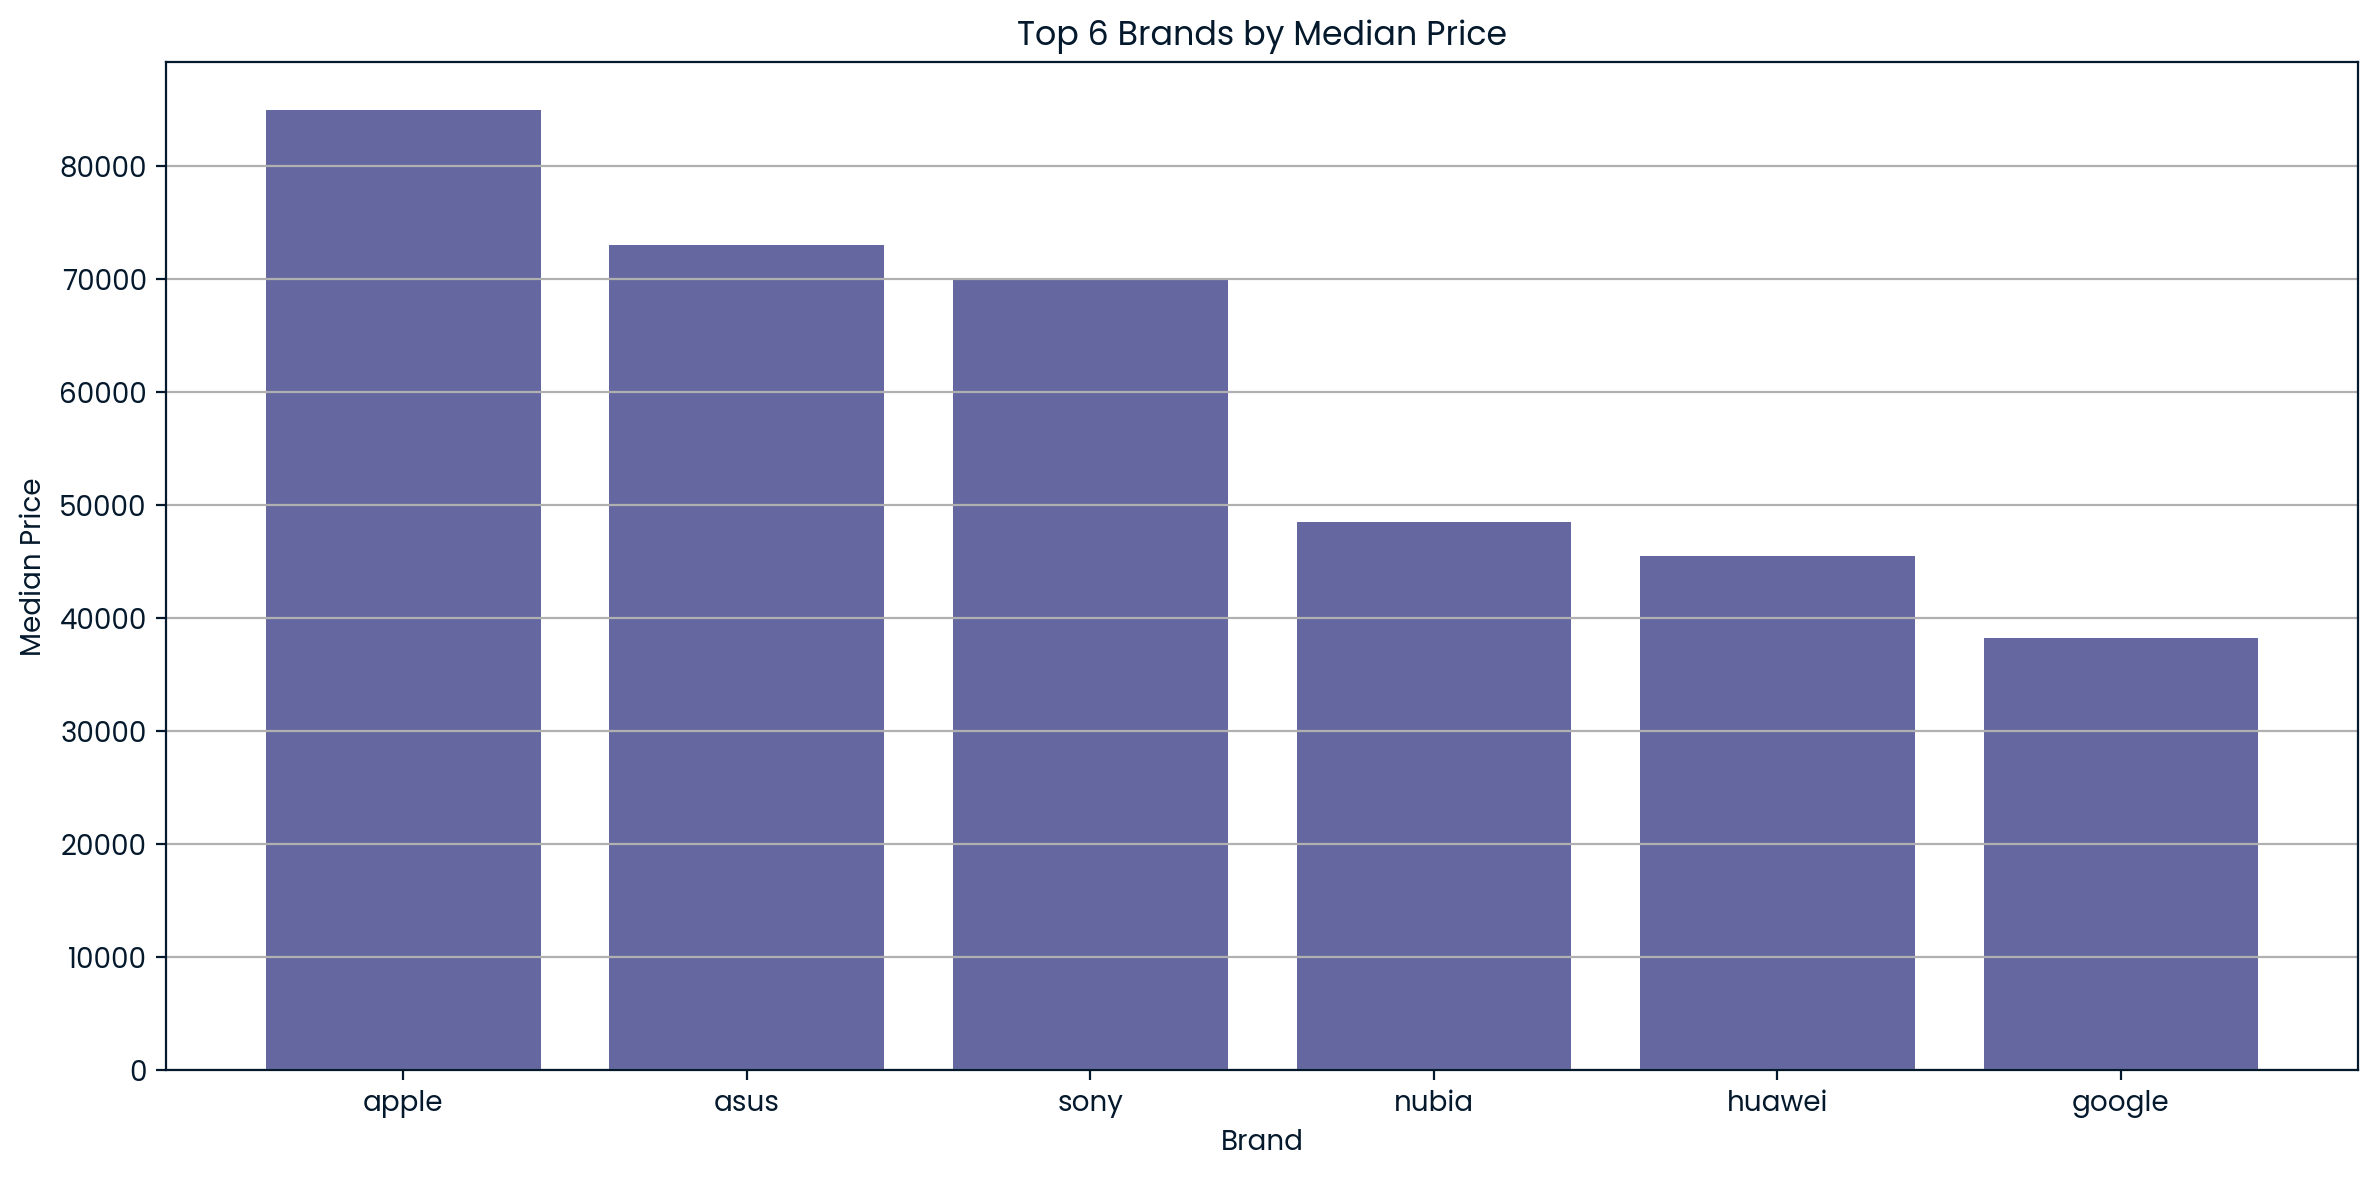

In [11]:
plt.figure(figsize=(12, 6))
brand_stats = df.groupby("brand_name")["price"].agg(["count","mean","median"])
top6 = brand_stats[brand_stats["count"]>=5].sort_values("median", ascending=False).head(6)
plt.bar(top6.index, top6["median"].values)
_finalize("Top 6 Brands by Median Price", xlabel="Brand", ylabel="Median Price",
          save_as="figures/top6_brands_median_price.png")

## Correlation with Price

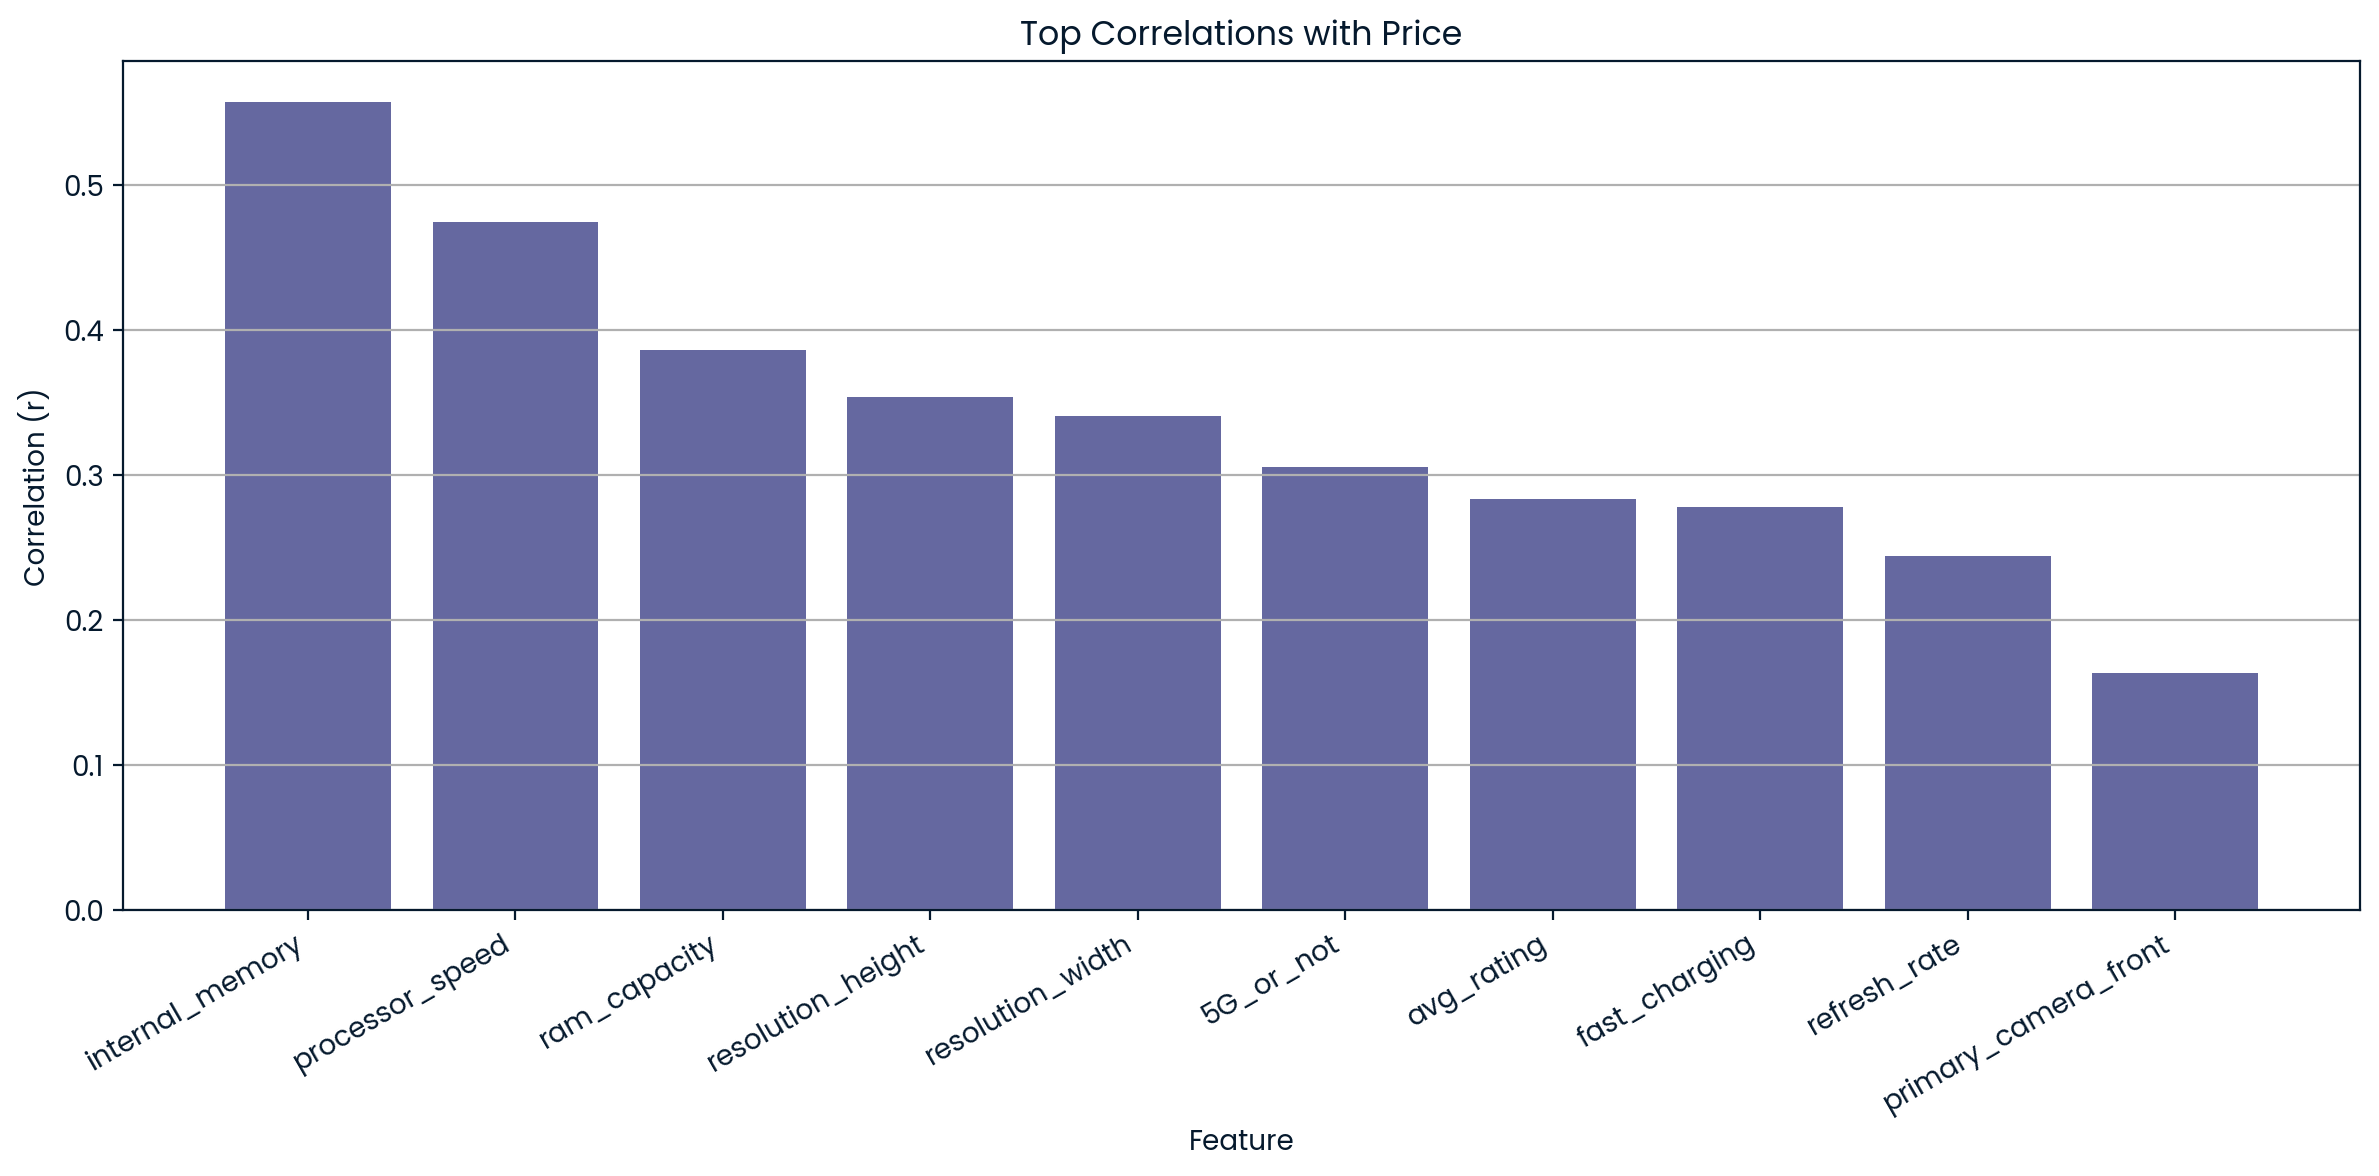

In [15]:
plt.figure(figsize=(12, 6))
corr_with_price = df[num_cols].corr()["price"].sort_values(ascending=False)
# keep top 10 (excluding 'price' itself)
corr_top = corr_with_price.drop(labels=["price"]).head(10)
plt.bar(corr_top.index, corr_top.values)
plt.xticks(rotation=30, ha="right")
_finalize("Top Correlations with Price", xlabel="Feature", ylabel="Correlation (r)",
          save_as="figures/corr_with_price_top10.png")

## Scatter: Price vs Processor Speed

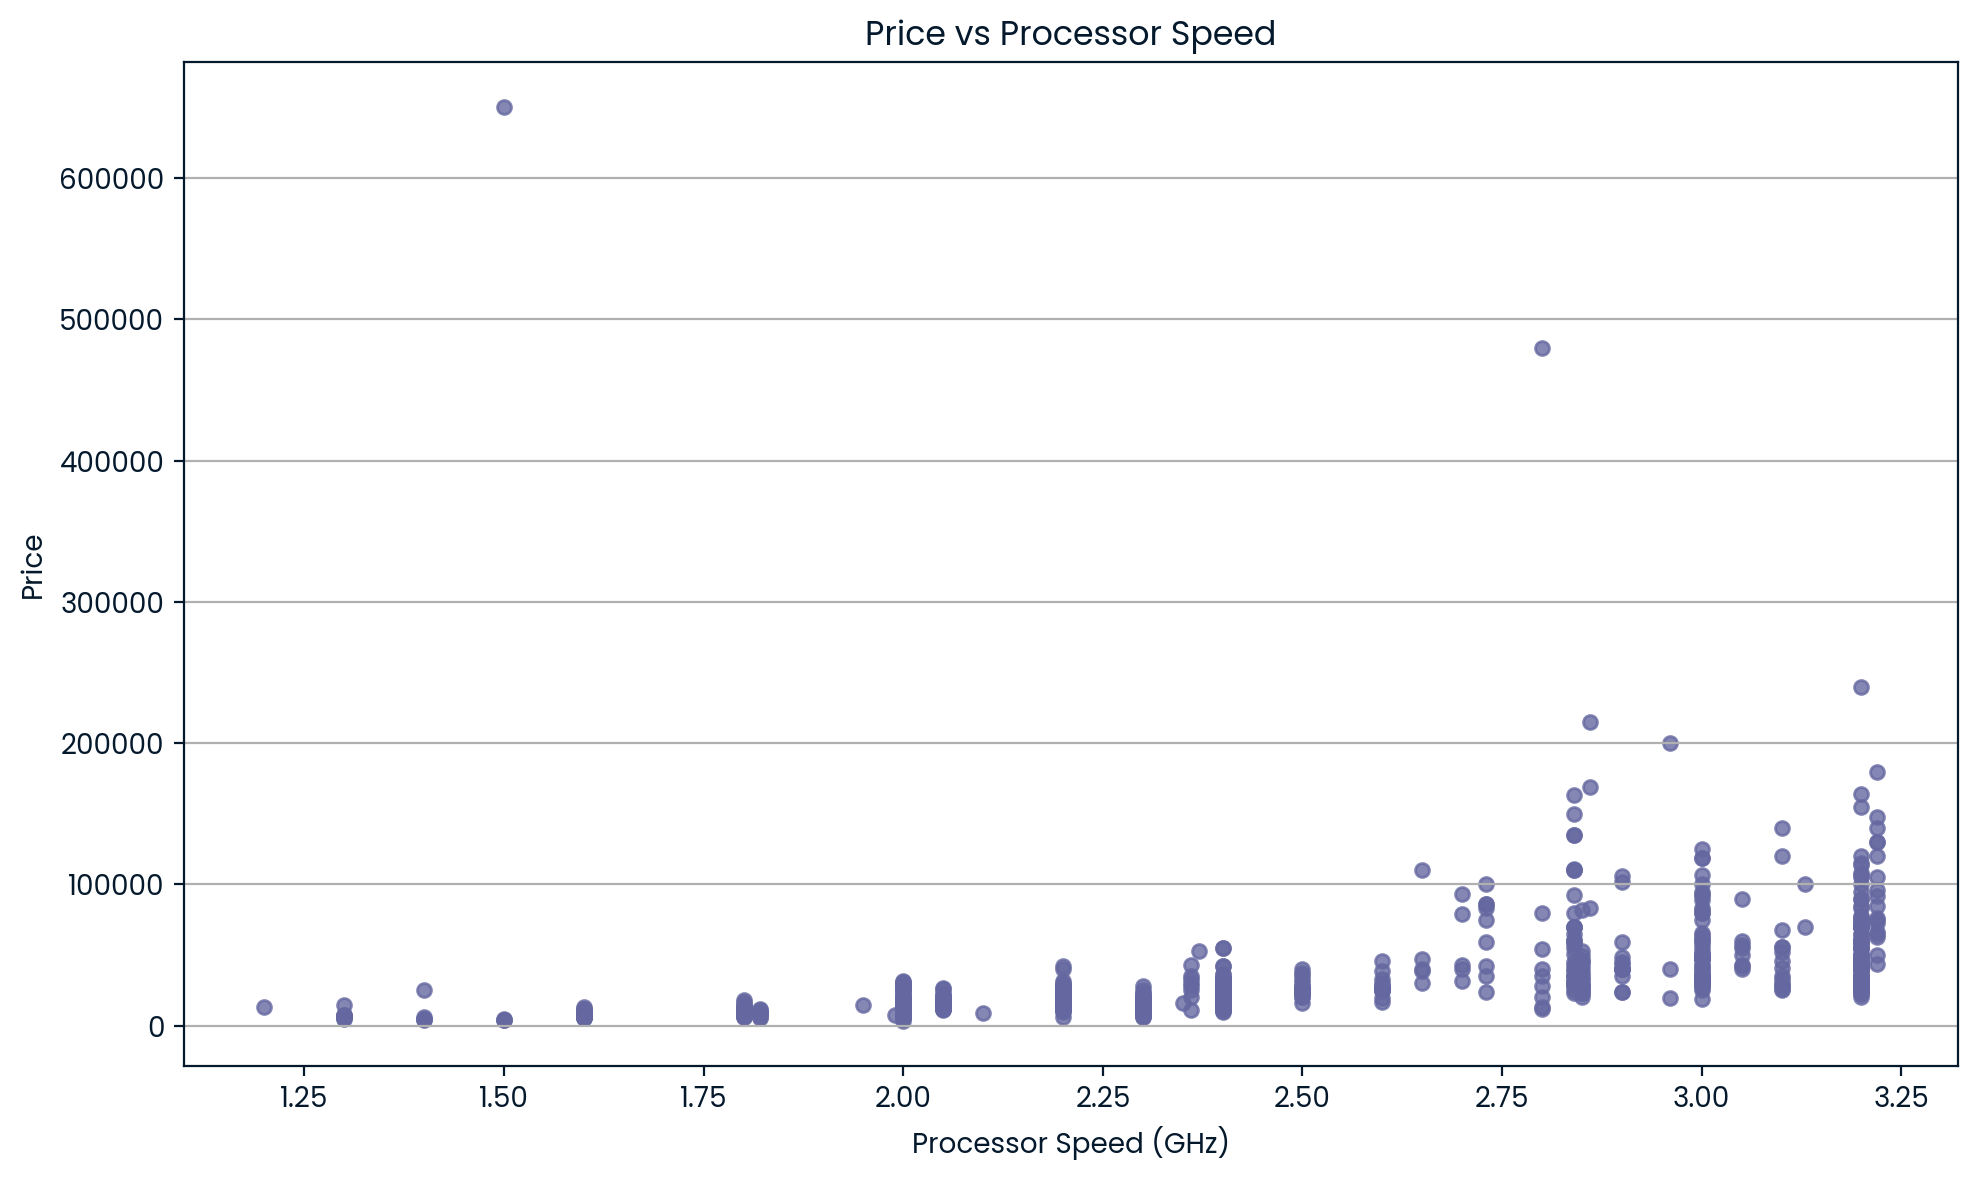

In [16]:
if {"price","processor_speed"}.issubset(df.columns):
    plt.figure(figsize=(10, 6))
    plt.scatter(df["processor_speed"], df["price"], s=25, alpha=0.8)
    _finalize("Price vs Processor Speed", xlabel="Processor Speed (GHz)", ylabel="Price",
              save_as="figures/price_vs_processor_speed.png")

## Scatter: Price vs Internal Memory

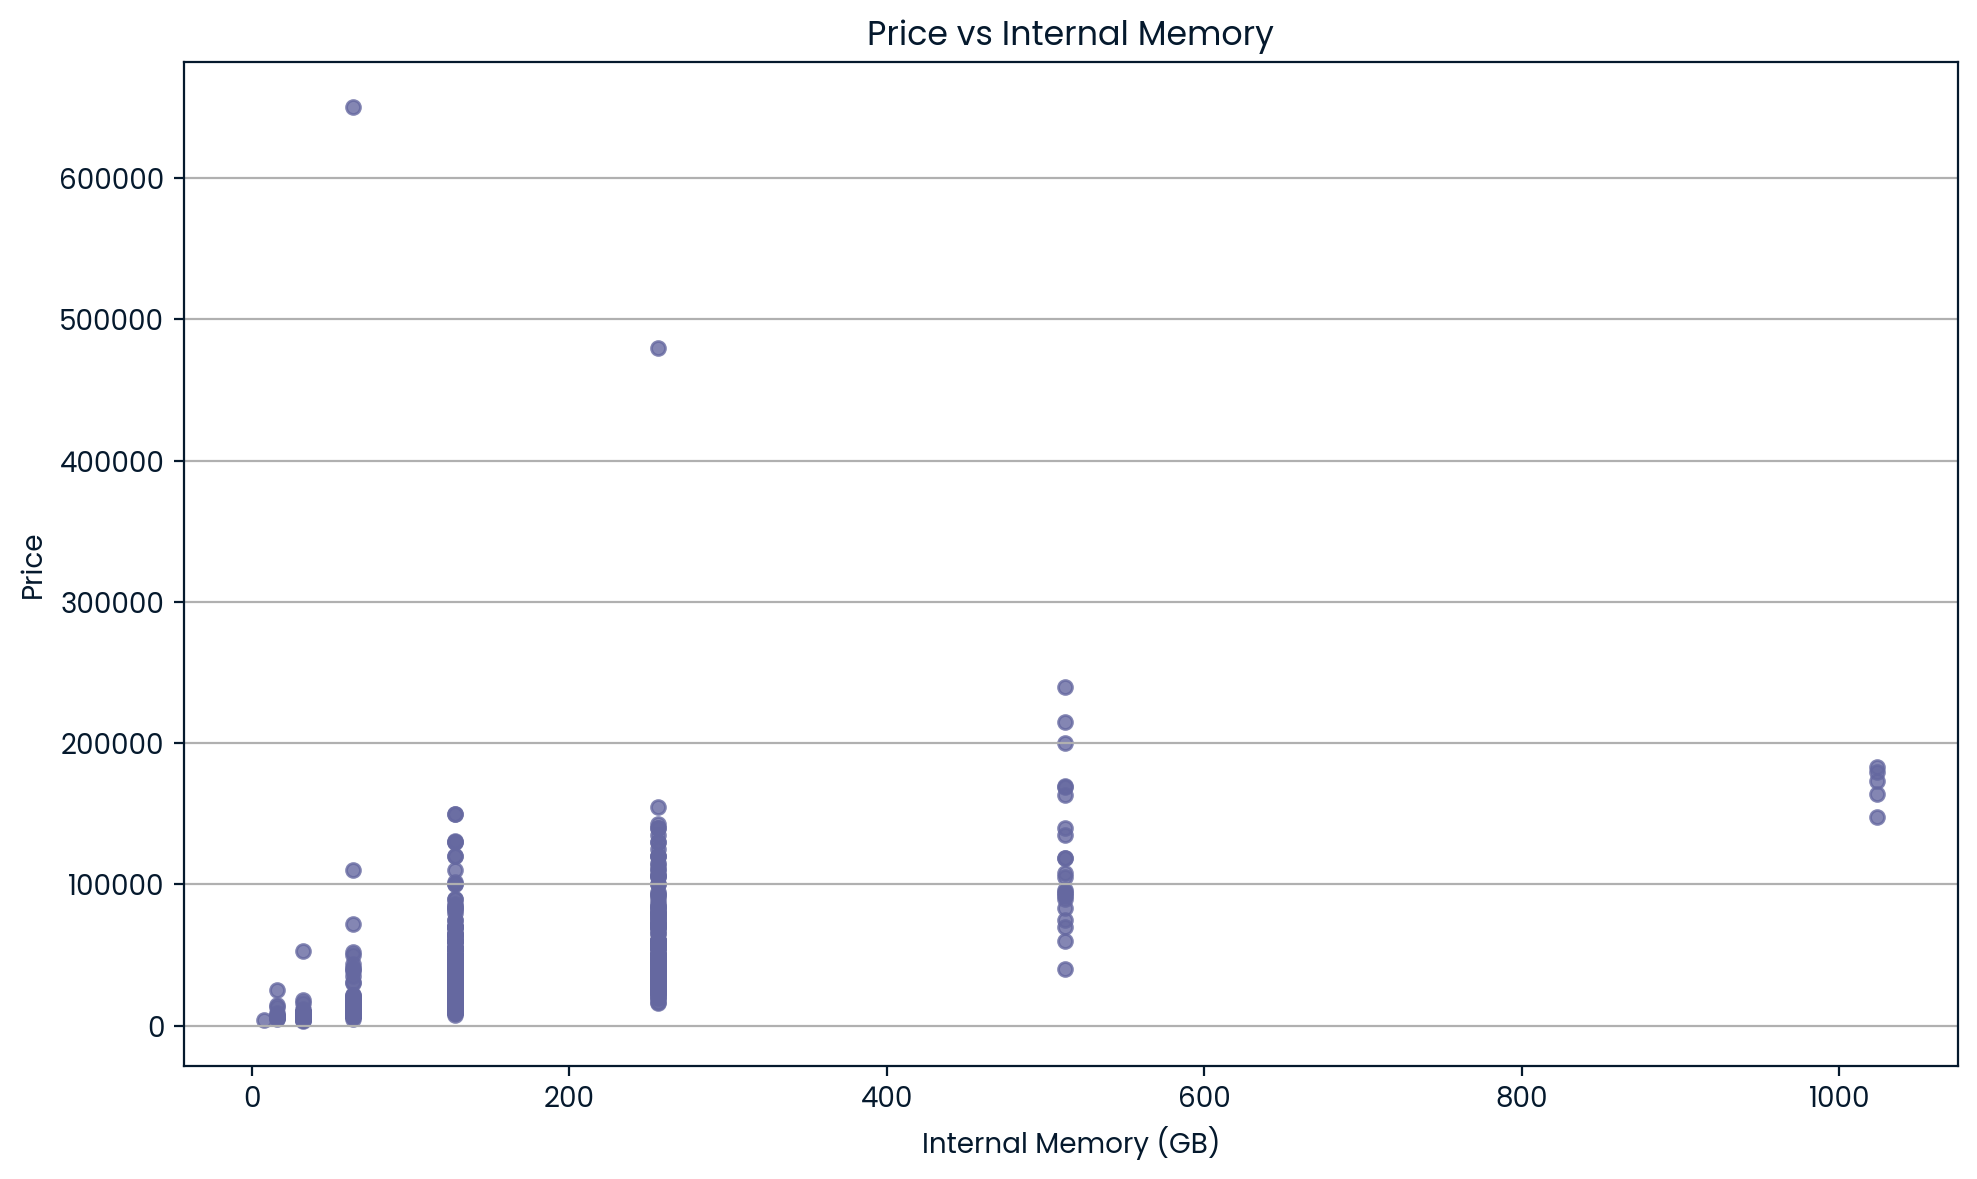

In [18]:
if {"price","internal_memory"}.issubset(df.columns):
    plt.figure(figsize=(10, 6))
    plt.scatter(df["internal_memory"], df["price"], s=25, alpha=0.8)
    _finalize("Price vs Internal Memory", xlabel="Internal Memory (GB)", ylabel="Price",
              save_as="figures/price_vs_internal_memory.png")

## Price by 5G availability

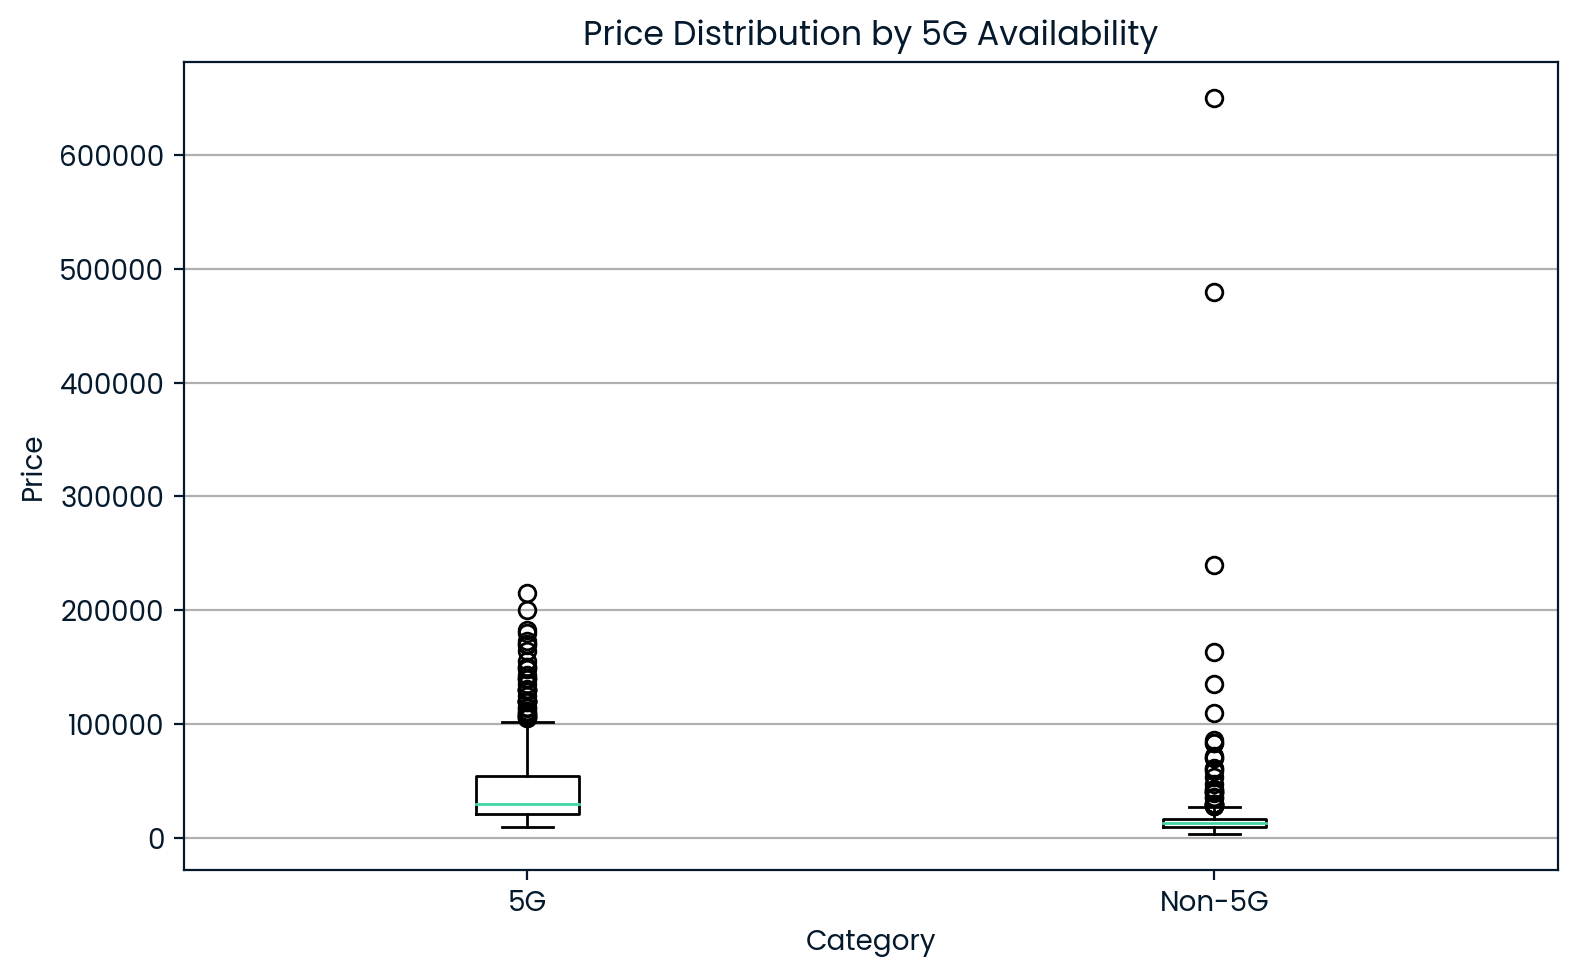

In [19]:
if {"price","5G_or_not"}.issubset(df.columns):
    plt.figure(figsize=(8, 5))
    groups = []
    labels = []
    for val, label in [(1, "5G"), (0, "Non-5G")]:
        subset = df.loc[df["5G_or_not"] == val, "price"].dropna().values
        if subset.size:
            groups.append(subset); labels.append(label)
    if groups:
        plt.boxplot(groups, labels=labels)
        _finalize("Price Distribution by 5G Availability", xlabel="Category", ylabel="Price",
                  save_as="figures/price_by_5g.png")

## Correlation heatmap (selected features)

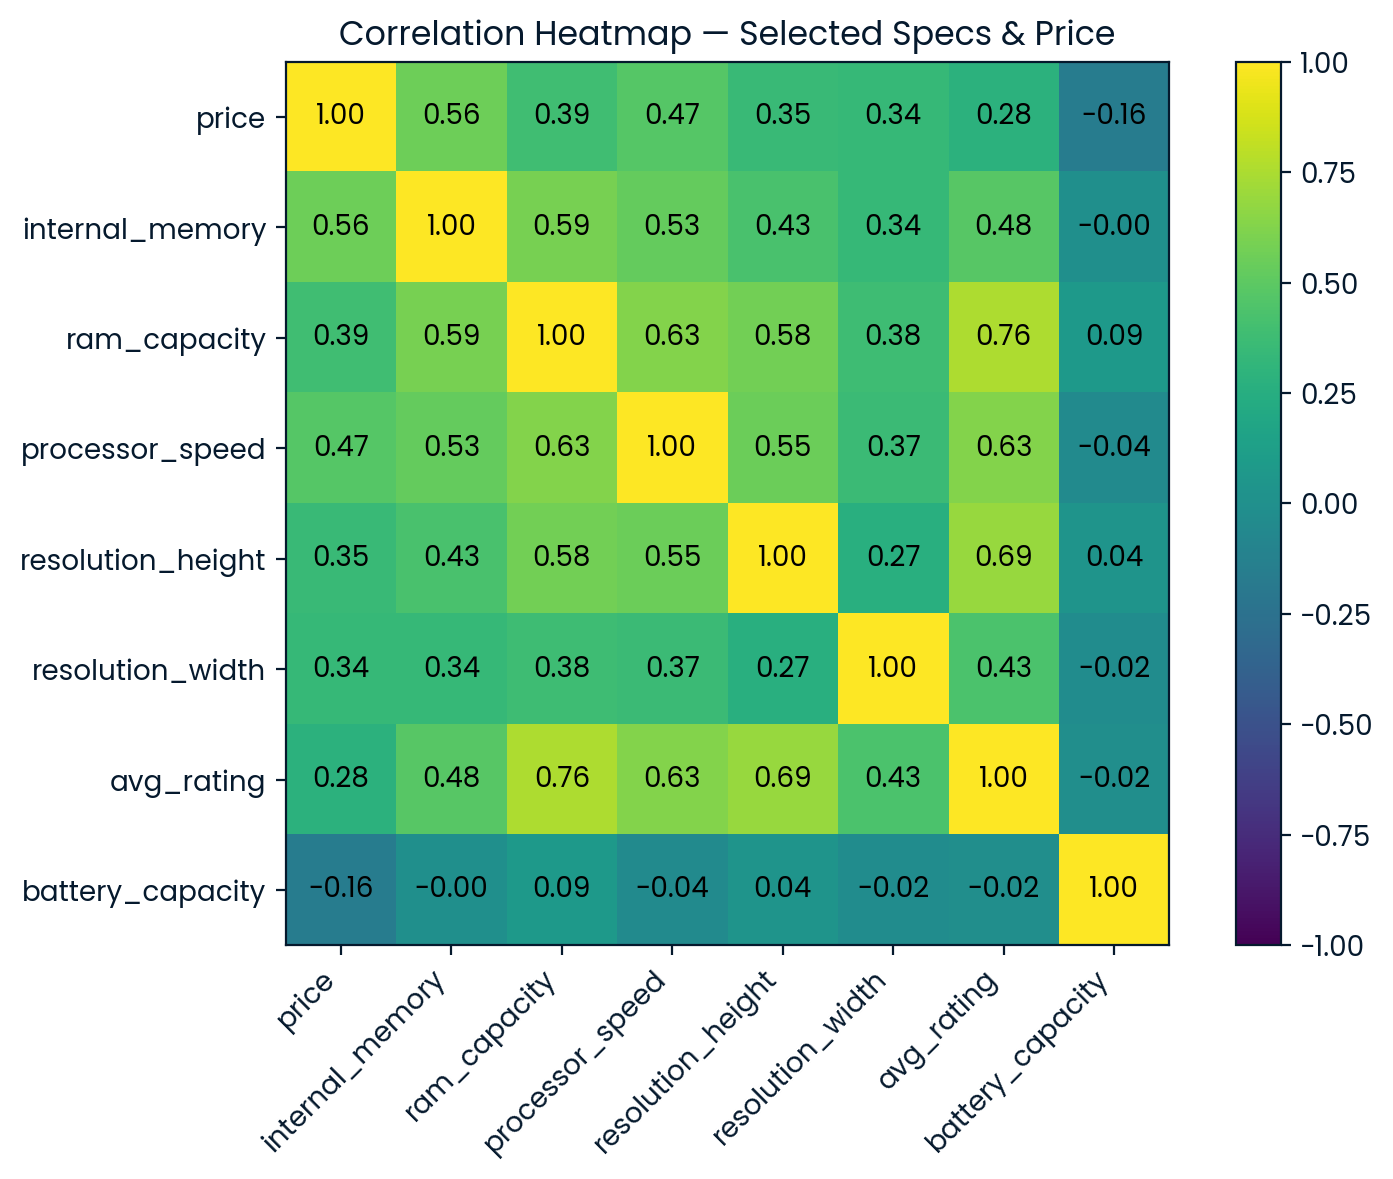

In [20]:
select_feats = [c for c in ["price","internal_memory","ram_capacity","processor_speed",
                            "resolution_height","resolution_width","avg_rating","battery_capacity"]
                if c in df.columns]
corr_mat = df[select_feats].corr()

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr_mat, vmin=-1, vmax=1)  # default colormap
ax.set_xticks(np.arange(len(select_feats))); ax.set_yticks(np.arange(len(select_feats)))
ax.set_xticklabels(select_feats, rotation=45, ha="right"); ax.set_yticklabels(select_feats)
for i in range(len(select_feats)):
    for j in range(len(select_feats)):
        ax.text(j, i, f"{corr_mat.iloc[i, j]:.2f}", ha="center", va="center", color="black")
ax.set_title("Correlation Heatmap — Selected Specs & Price")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig("figures/corr_heatmap_selected.png", dpi=200)
plt.show()